In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

Using TensorFlow backend.


using Keras version: 2.2.4


# Building a Chinese-Language Sentiment Analyzer

In this notebook, we will build a Chinese-language text classification model in 4 simple steps. More specifically, we will build a model that classifies Chinese hotel reviews as either positive or negative.

The dataset can be downloaded from Chengwei Zhang's GitHub repository [here](https://github.com/Tony607/Chinese_sentiment_analysis/tree/master/data/ChnSentiCorp_htl_ba_6000).

(**Disclaimer:** I don't speak Chinese. Please forgive mistakes.)  

## STEP 1:  Load and Preprocess the Data

First, we use the `texts_from_folder` function to load and preprocess the data.  We assume that the data is in the following form:
```
    ├── datadir
    │   ├── train
    │   │   ├── class0       # folder containing documents of class 0
    │   │   ├── class1       # folder containing documents of class 1
    │   │   ├── class2       # folder containing documents of class 2
    │   │   └── classN       # folder containing documents of class N
```
We set `val_pct` as 0.1, which will automatically sample 10% of the data for validation.  Since we will be using a pretrained BERT model for classification, we specifiy `preprocess_mode='bert'`.  If you are using any other model (e.g., `fasttext`), you should either omit this parameter or use `preprocess_mode='standard'`).

**Notice that there is nothing speical or extra we need to do here for non-English text.**  *ktrain* automatically detects the language and character encoding and prepares the data and configures the model appropriately.



In [3]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder('data/ChnSentiCorp_htl_ba_6000', 
                                                                       maxlen=100, 
                                                                       max_features=30000,
                                                                       preprocess_mode='standard',
                                                                       train_test_names=['train'],
                                                                       val_pct=0.1,
                                                                       ngram_range=3,
                                                                       classes=['pos', 'neg'])

detected encoding: GB18030
Decoding with GB18030 failed 1st attempt - using GB18030 with skips
skipped 107 lines (0.3%) due to character decoding errors
skipped 11 lines (0.3%) due to character decoding errors


Building prefix dict from the default dictionary ...
I1001 17:33:09.975814 140013155014464 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
I1001 17:33:09.978070 140013155014464 __init__.py:131] Loading model from cache /tmp/jieba.cache


language: zh-cn


Loading model cost 0.652 seconds.
I1001 17:33:10.629599 140013155014464 __init__.py:163] Loading model cost 0.652 seconds.
Prefix dict has been built succesfully.
I1001 17:33:10.631566 140013155014464 __init__.py:164] Prefix dict has been built succesfully.


Word Counts: 22388
Nrows: 5324
5324 train sequences
Average train sequence length: 82
Adding 3-gram features
max_features changed to 457800 with addition of ngrams
Average train sequence length with ngrams: 245
x_train shape: (5324,100)
y_train shape: (5324,2)
592 test sequences
Average test sequence length: 75
Average test sequence length with ngrams: 183
x_test shape: (592,100)
y_test shape: (592,2)


## STEP 2:  Create a Model and Wrap in Learner Object

In [4]:
model = text.text_classifier('nbsvm', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

Is Multi-Label? False
compiling word ID features...
maxlen is 100
building document-term matrix... this may take a few moments...
rows: 1-5324
computing log-count ratios...
done.


## STEP 3: Estimate the LR
We'll use the *ktrain* learning rate finder to find a good learning rate to use with *fasttext*.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
5324/5324 [==============================] - 1s 245us/step - loss: 0.6923 - acc: 0.5255
Epoch 2/1024
5324/5324 [==============================] - 1s 169us/step - loss: 0.6915 - acc: 0.5385
Epoch 3/1024
5324/5324 [==============================] - 1s 161us/step - loss: 0.6872 - acc: 0.6056
Epoch 4/1024
5324/5324 [==============================] - 1s 167us/step - loss: 0.6653 - acc: 0.7979
Epoch 5/1024
5324/5324 [==============================] - 1s 174us/step - loss: 0.5744 - acc: 0.9303
Epoch 6/1024
5324/5324 [==============================] - 1s 173us/step - loss: 0.3491 - acc: 0.9699
Epoch 7/1024
5324/5324 [==============================] - 1s 170us/step - loss: 0.1122 - acc: 0.9900
Epoch 8/1024
5324/5324 [==============================] - 1s 172us/step - loss: 0.0244 - acc: 0.9962
Epoch 9/1024
5324/5324 [==============================] - 1s 171us/step - loss: 0.0106 - acc: 0.9968
Epoch 10

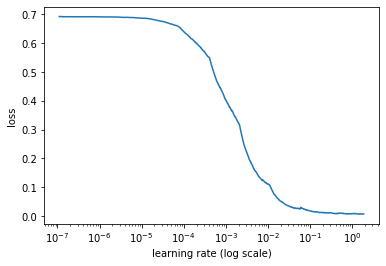

In [5]:
learner.lr_find(show_plot=True)

## STEP 3: Train the Model

We will use the `autofit` method that employs a triangular learning rate policy with EarlyStopping and ReduceLROnPlateau automatically enabled, since the epochs argument is omitted. We monitor `val_acc`, so weights from the epoch with the highest validation accuracy will be automatically loaded into our model when training completes.

As shown in the cell below, our final validation accuracy is **92%** with only 7 seconds of training!

In [6]:
learner.autofit(7e-3, monitor='val_acc')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.007...
Train on 5324 samples, validate on 592 samples
Epoch 1/1024
5324/5324 [==============================] - 1s 219us/step - loss: 0.3265 - acc: 0.8924 - val_loss: 0.2218 - val_acc: 0.9139
Epoch 2/1024
5324/5324 [==============================] - 1s 208us/step - loss: 0.0274 - acc: 0.9951 - val_loss: 0.2047 - val_acc: 0.9155
Epoch 3/1024
5324/5324 [==============================] - 1s 204us/step - loss: 0.0166 - acc: 0.9968 - val_loss: 0.2060 - val_acc: 0.9155
Epoch 4/1024
5324/5324 [==============================] - 1s 206us/step - loss: 0.0137 - acc: 0.9968 - val_loss: 0.2062 - val_acc: 0.9206
Epoch 5/1024
5324/5324 [==============================] - 1s 213us/step - loss: 0.0120 - acc: 0.9970 - val_loss: 0.2078 - val_acc: 0.9189
Epoch 6/1024
5324/5324 [==============================] - 1s 204us/step - loss:

In [7]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

         neg       0.91      0.94      0.92       310
         pos       0.93      0.89      0.91       282

    accuracy                           0.92       592
   macro avg       0.92      0.91      0.92       592
weighted avg       0.92      0.92      0.92       592



array([[290,  20],
       [ 30, 252]])

### Inspecting the Misclassifications

In [8]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:294 | loss:5.13 | true:neg | pred:pos)

酒店 环境 还 不错 ， 装修 也 很 好 。 早餐 不怎么样 ， 价格 偏高 。


Using Google Translate, the above roughly translates to:
```
The hotel environment is not bad, the decoration is also very good. Breakfast is not good, the price is high.
```

This is a mixed review, but is labeled only as negative.  Our classifier is undertandably confused and predicts positive for this reivew.

### Making Predictions on New Data

In [9]:
p = ktrain.get_predictor(learner.model, preproc)

Predicting label for the text
> "*I despise the service of this hotel.*"

In [10]:
p.predict("我鄙视这家酒店的服务。")

'neg'

Predicting label for:
> "*I like the service of this hotel.*"

In [11]:
p.predict('我喜欢这家酒店的服务')

'pos'